# <center>Summary of a seminal paper on Deep Learning: Generative Adversarial Nets</center>

**<center>Pablo Cabra Montes, Alexandra Pritoula, Alice Scattolin <br/>
Geneva School of Economics and Management (GSEM)<br/>
Université de Genève (UNIGE), <br/>
Genève, Suisse</center>**


## IMPLEMENTATION ON MINST DATASET

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [10]:
torch.manual_seed(111) # Set seet to ensure reproducibility
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # First transform the data into Tensor data type, then it normalize it
train_set = torchvision.datasets.FashionMNIST(root=".", train=True, download=True, transform=transform) # Download the dataset
batch_size = 32 # Define the size of the minibatcg
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True) # Pass the data through the transformation process

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [35]:
len(train_set[0][0][0][0])

28

In [36]:
train_set.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

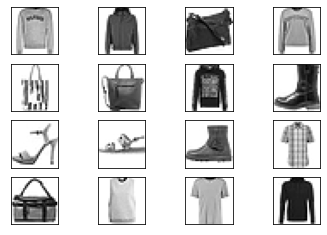

In [40]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [41]:
# DISCRIMINTATOR CLASS
# It is a MLP neural network defined in a sequential way using nn.Sequential()
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__() # Run .__init__() from nn.Module.
        self.model = nn.Sequential(
             nn.Linear(784, 1024), # The input has 784 elements. The first hidden layer is composed of 1024 neurons.
             nn.LeakyReLU(), # The first hidden layer has a ReLU activation function.
             nn.Dropout(0.4), # It's purpose is to avoid overfitting.
             nn.Linear(1024, 512), # The second hidden layer is composed of 512 neurons.
             nn.LeakyReLU(), # The second hidden layer has a ReLU activation function.
             nn.Dropout(0.4), # It's purpose is to avoid overfitting.
             nn.Linear(512, 256), # The third hidden layer is composed of 256 neurons.
             nn.LeakyReLU(), # The third hidden layer has a ReLU activation function.
             nn.Dropout(0.4), # It's purpose is to avoid overfitting.
             nn.Linear(256, 1), # The output layer has one dimension.
             nn.Sigmoid(), # The output layer has a sigmoidal activation to represent a probability
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
    

discriminator = Discriminator()

In [42]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
             nn.Linear(100, 256), # The input has 100 elements. The first hidden layer is composed of 256 neurons.
             nn.ReLU(), # The first hidden layer has a ReLU activation function
             nn.Linear(256, 512), # The second hidden layer is composed of 512 neurons.
             nn.ReLU(), # The second hidden layer has a ReLU activation function
             nn.Linear(512, 1024), # The third hidden layer is composed of 1024 neurons.
             nn.ReLU(), # The third hidden layer has
             nn.Linear(1024, 784), # The output layer is composed of 784 neurons.
             nn.Tanh(), # The output layer has hyperbolic tangent function  activation function.
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator()

In [43]:
# PARAMETERS TO TRAIN THE MODEL
lr = 0.0003 # Learning rate
num_epochs = 50 # Numer of repetitions of the training.
loss_function = nn.BCELoss() # Loss function

# OPTIMIZATION METHOD USED TO TRAIN THE MODEL
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr) # Stochastic gradient descent to train the discriminator model
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr) # Stochastic gradient descent to train the generative model

In [44]:
# TRAINING THE MODEL
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 100))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 5 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.20719368755817413
Epoch: 0 Loss G.: 2.539905548095703
Epoch: 5 Loss D.: 0.39910683035850525
Epoch: 5 Loss G.: 1.2485579252243042
Epoch: 10 Loss D.: 0.5696784257888794
Epoch: 10 Loss G.: 1.0492160320281982
Epoch: 15 Loss D.: 0.6553128361701965
Epoch: 15 Loss G.: 0.8274165391921997
Epoch: 20 Loss D.: 0.7037631869316101
Epoch: 20 Loss G.: 0.7351340055465698
Epoch: 25 Loss D.: 0.695407509803772
Epoch: 25 Loss G.: 0.7104607820510864
Epoch: 30 Loss D.: 0.720880389213562
Epoch: 30 Loss G.: 0.8016178607940674
Epoch: 35 Loss D.: 0.6628212928771973
Epoch: 35 Loss G.: 0.7462495565414429
Epoch: 40 Loss D.: 0.6526761054992676
Epoch: 40 Loss G.: 0.7455395460128784
Epoch: 45 Loss D.: 0.6806113123893738
Epoch: 45 Loss G.: 0.6834997534751892


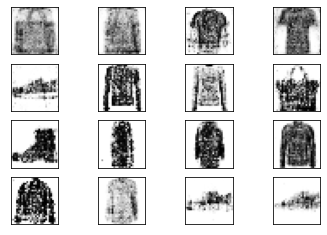

In [45]:
# CHECK THE SAMPLES
latent_space_samples = torch.randn(batch_size, 100)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])